<a href="https://colab.research.google.com/github/jeonyeohun/2020_2_DeepLearning_Application/blob/master/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving student-mat.csv to student-mat.csv
Saving student-por.csv to student-por.csv
User uploaded file "student-mat.csv" with length 56993 bytes
User uploaded file "student-por.csv" with length 93220 bytes


In [636]:
import pandas as pd
stu_mat = pd.read_csv('student-mat.csv', sep=';')

In [637]:
target_col = stu_mat['G3']
input_cols = stu_mat.drop(['G1', 'G2', 'G3'], axis=1)
input_cols = pd.get_dummies(input_cols, dummy_na=True)
print(input_cols.shape)

(395, 73)


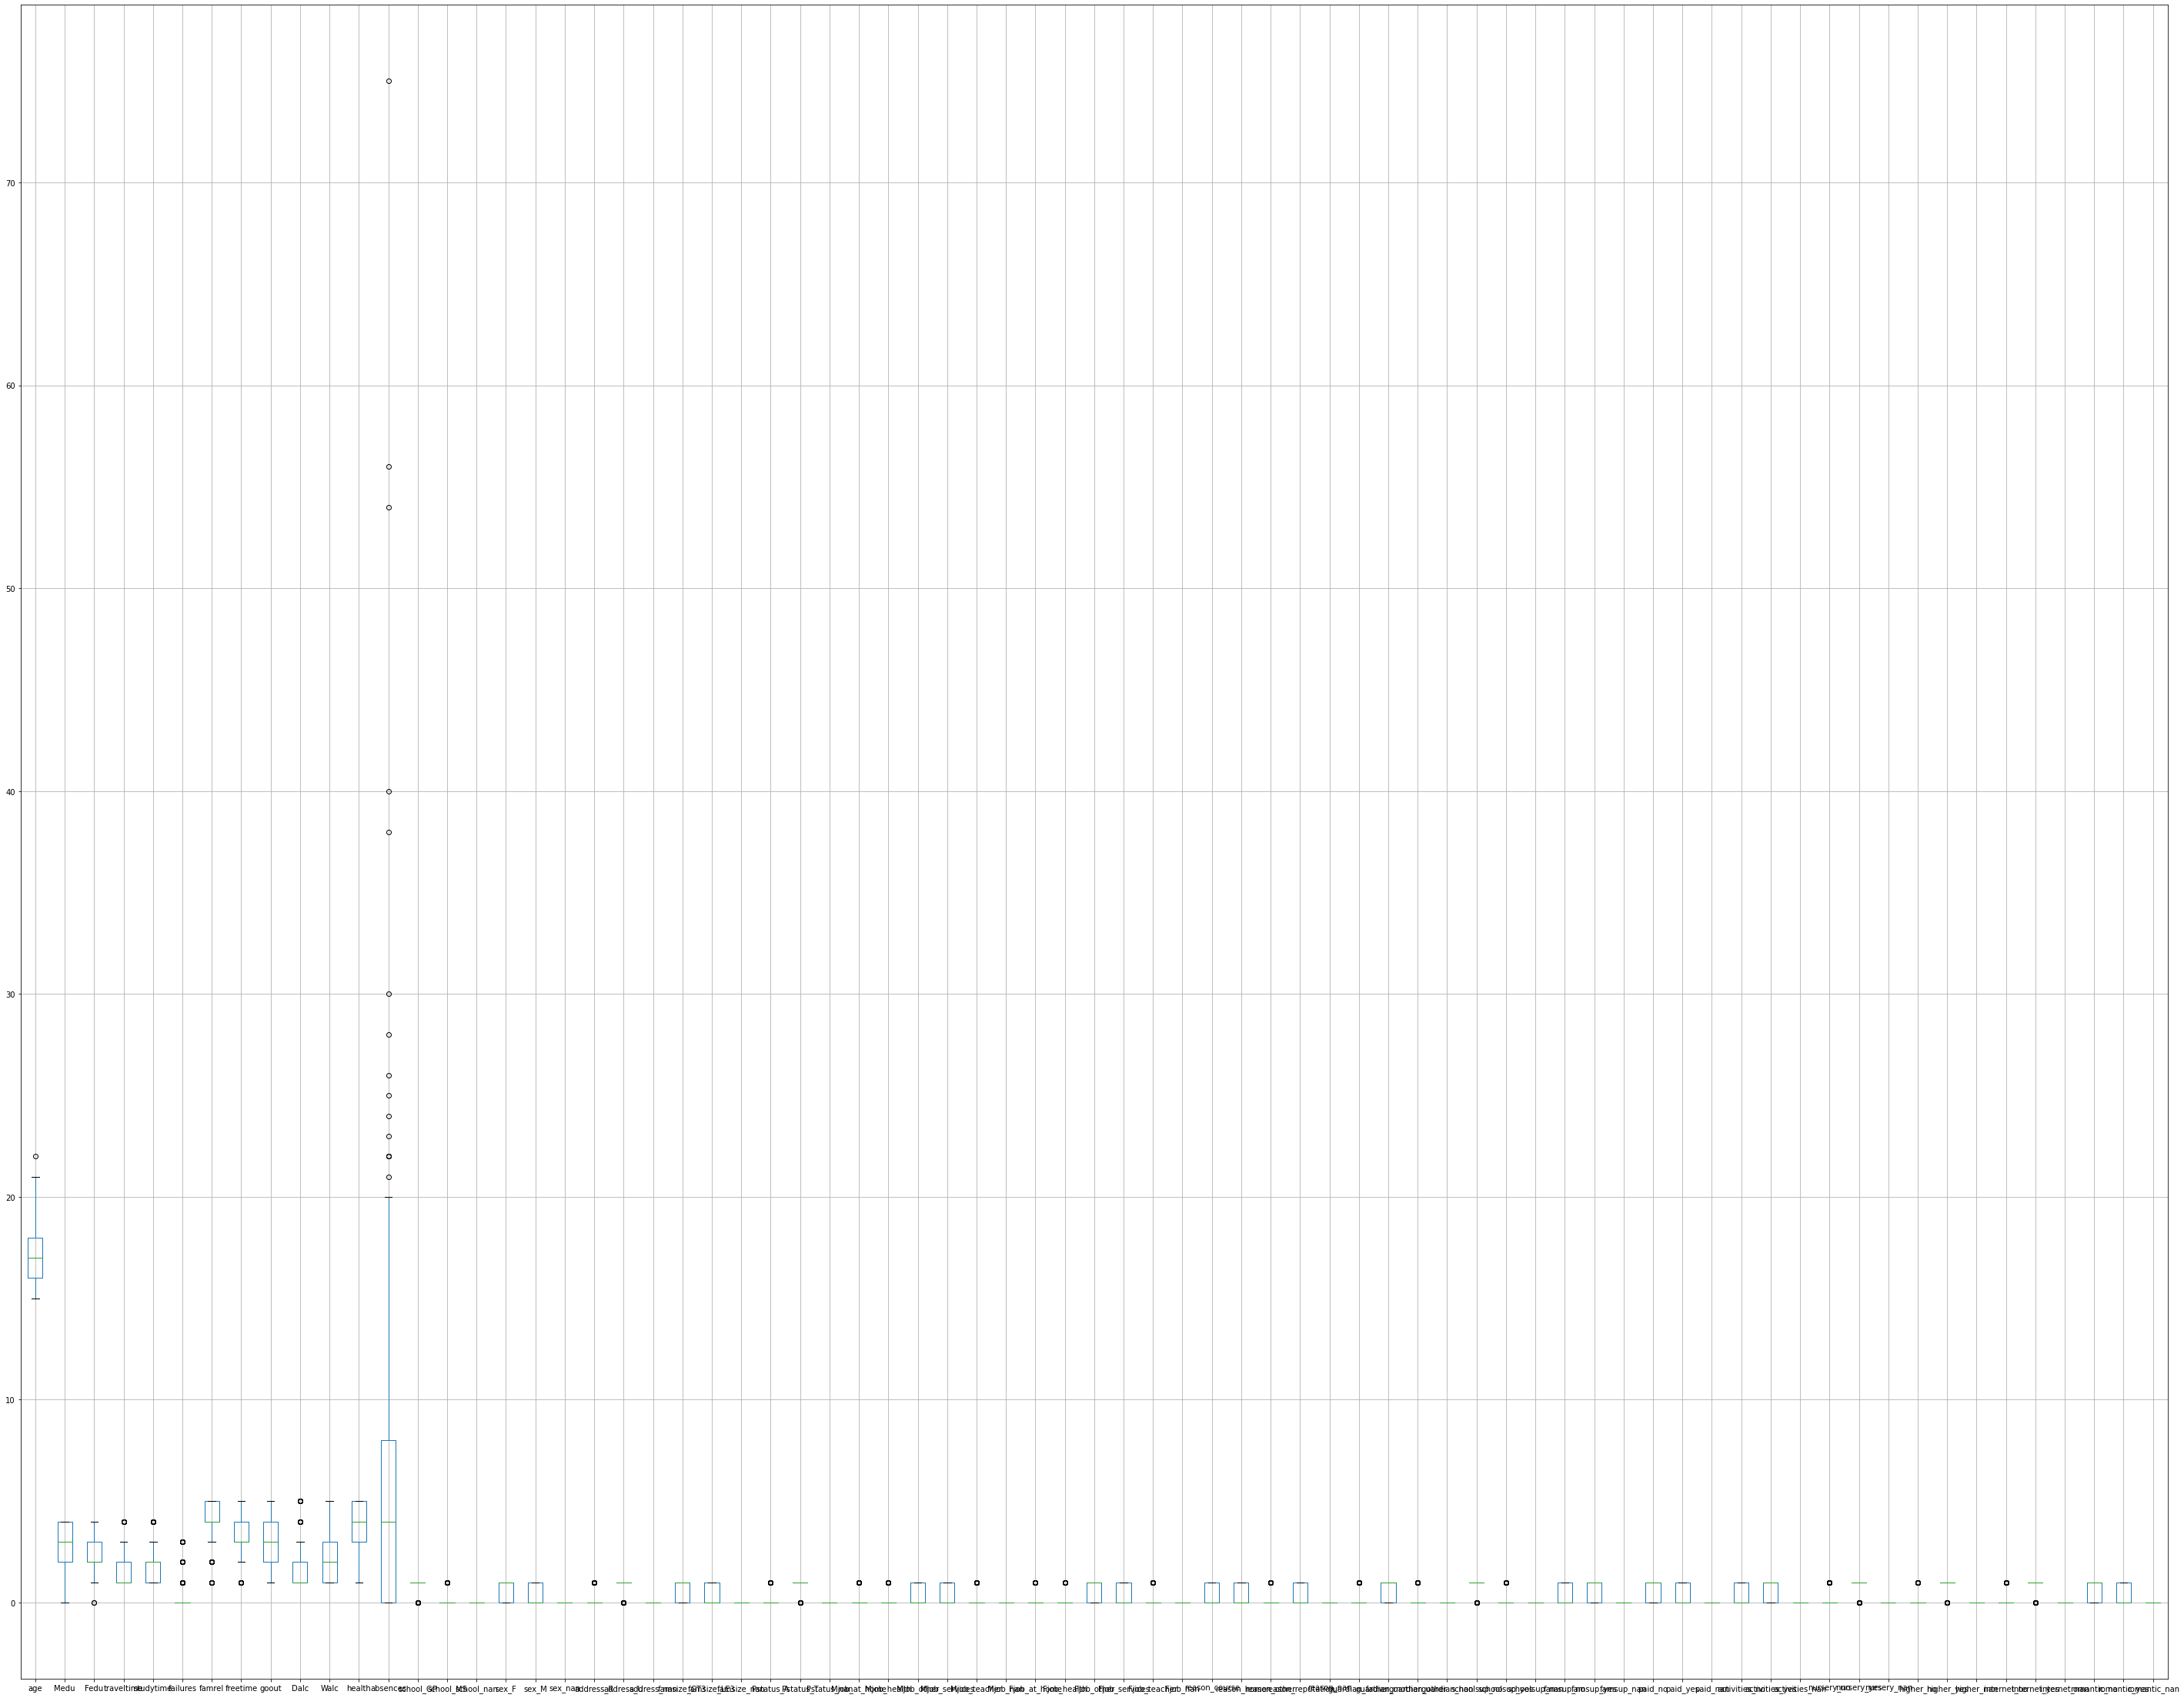

In [638]:
pd.DataFrame.boxplot(input_cols, figsize=(50, 40))

(200, 73)
(200,)


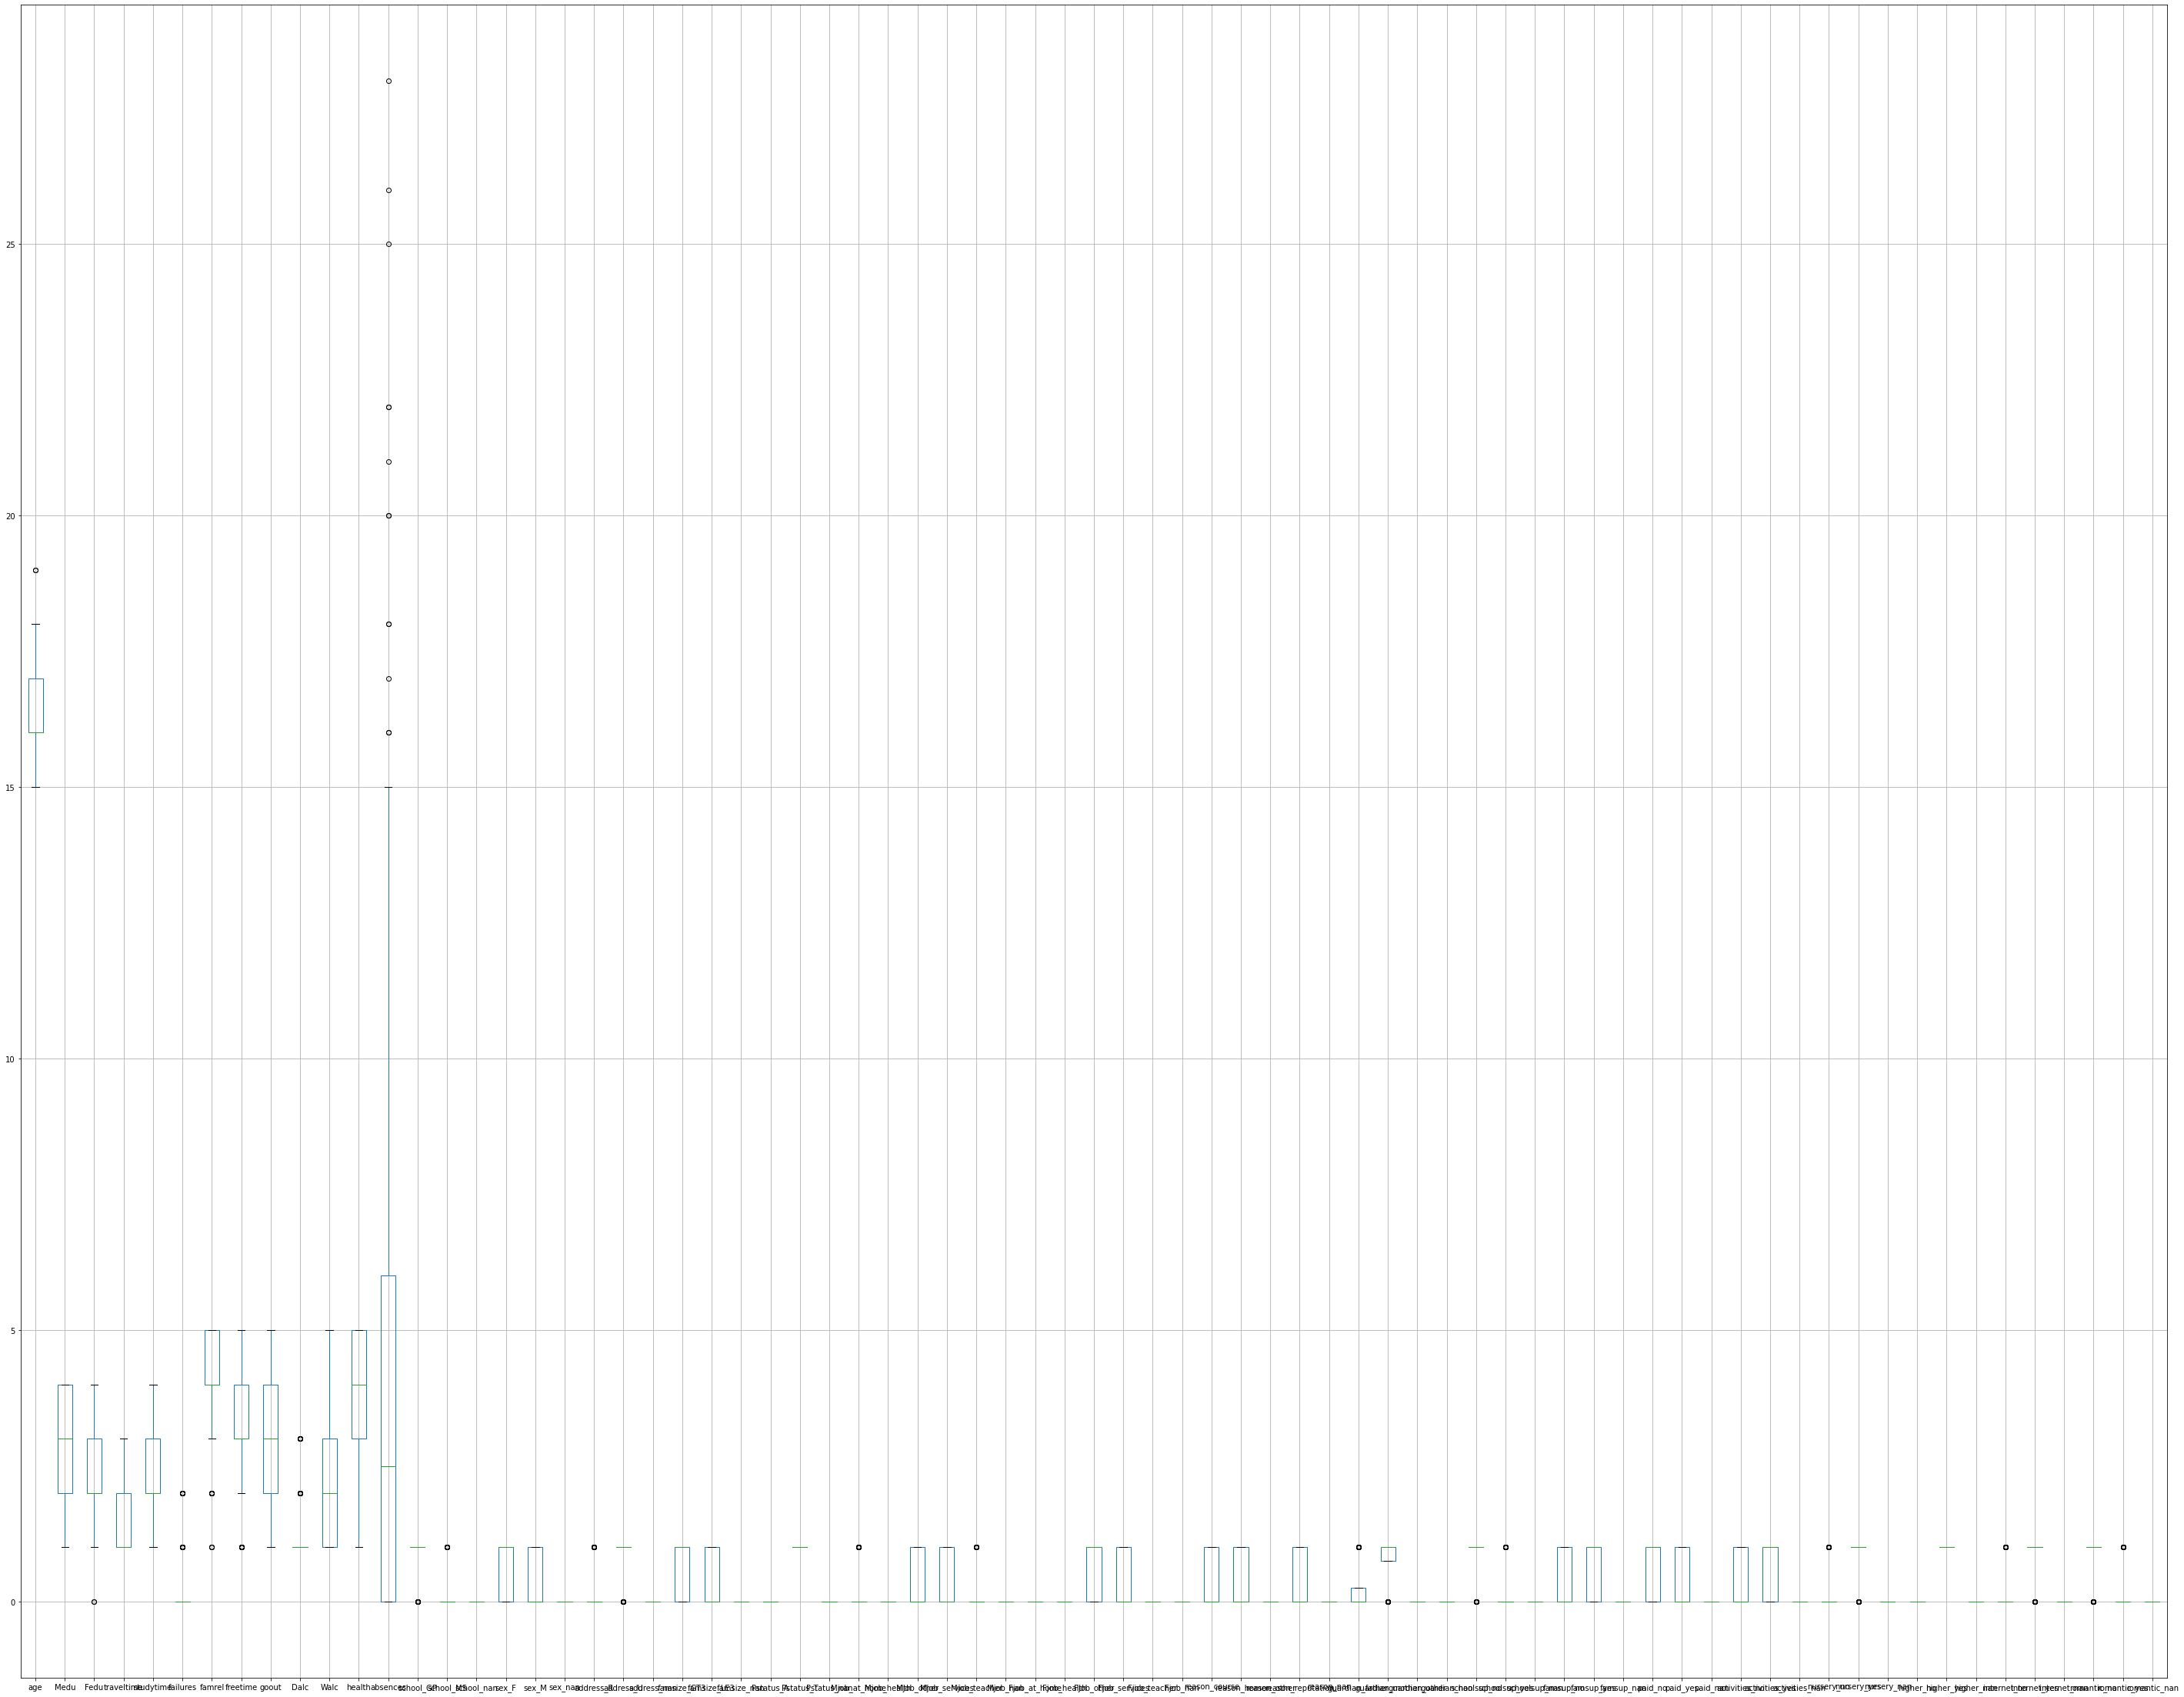

In [639]:
for col in input_cols.columns:
  Q1 = input_cols[col].quantile(0.10)
  Q3 = input_cols[col].quantile(0.90)
  IQR = Q3 - Q1    #IQR is interquartile range. 
  filter = (input_cols[col] >= Q1 - 1.5 * IQR) & (input_cols[col] <= Q3 + 1.5 * IQR)
  input_cols = input_cols.loc[filter]
  target_col = target_col.loc[filter]
pd.DataFrame.boxplot(input_cols, figsize=(50, 40))
print(input_cols.shape)
print(target_col.shape)

In [640]:
import numpy as np

In [641]:
change = input_cols.sample(5).index
input_cols.loc[change, 'traveltime'] = np.nan
print(input_cols.loc[change]['traveltime'])

input_cols = input_cols.fillna(method='bfill')
print(input_cols.loc[change]['traveltime'])

print(input_cols.shape)

267   NaN
92    NaN
367   NaN
11    NaN
338   NaN
Name: traveltime, dtype: float64
267    1.0
92     2.0
367    2.0
11     2.0
338    1.0
Name: traveltime, dtype: float64
(200, 73)


In [642]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms

print(torch.__version__)

1.7.0+cu101


In [643]:
from sklearn.model_selection import train_test_split

input_cols = input_cols.to_numpy();
target_col = target_col.to_numpy();

X_train, X_test, y_train, y_test = train_test_split(input_cols, target_col, test_size=0.2, random_state=42)

In [644]:
MODEL_NAME = 'GMLP'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [645]:
class GMLP(nn.Module):
  def __init__(self, input_size=73, num_classes=21):
    super(GMLP, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input_size, 32),
        nn.ReLU(),

        nn.Linear(32, 32),
        nn.ReLU(),

        nn.Linear(32, num_classes),
    )
  
  def forward(self, x):
    y_ = x.view(x.size(0), -1)
    y_ = self.mlp(y_)
    return y_
    

In [646]:
model = GMLP().to(DEVICE)

In [647]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
stu_train = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(dataset=stu_train, batch_size=5, shuffle=True, drop_last=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)
stu_test = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(dataset=stu_test, batch_size=5, shuffle=False, drop_last=False)

In [648]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [649]:
# set loss function
loss_fn = nn.CrossEntropyLoss()

# set optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.0025)

# reset loss history
all_losses = []

In [652]:
max_epoch = 100        # maximum number of epochs
step = 0             # initialize step counter variable

plot_every = 30
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in range(max_epoch):
  for idx, samples in enumerate(train_loader):
        x, y = samples

        y_hat = model(x)            # forward propagation, y_hat.shape = (N, 10) 

        loss = loss_fn(y_hat, y)    # computing loss
        total_loss += loss.item()
        
        optim.zero_grad()           # reset gradient
        loss.backward()             # back-propagation (compute gradient)
        optim.step()                # update parameters with gradient
        
        # periodically print loss
        if step % 5 == 0:
            print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        # periodically evalute model on test data
        if step % 5 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():   # disable autograd
                for idx, samples in enumerate(test_loader):
                    x, y = samples 
                    y_hat = model(x) 
                    loss = loss_fn(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)     # find maxmum along the last axis (argmax of each row)
                    # 언더바는 맥스 값을 받고 그냥 버리는 변수로 사용하고 진짜 중요한건 맥스값을 가지는 인덱스를 indices 에 저장하는 것
                                                              # ex) max_value, max_idx = torch.max(input, dim)
                    acc += torch.sum(indices == y).item()     # count correctly classified samples
                                                              # torch.sum() returns Tensor. Tensor.item() converts it to a value
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, test accuracy: {} %'.format(step, loss.item(), acc/len(stu_test)*100)) # 정인식된 데이터 개수를 전체 데이터 개수로 나눈다 = 인식률
            print('*'*46)
            model.train()           # turn to train mode (enable autograd)
        step += 1

Epoch(0m 0s): 0/100, Step: 0, Loss: 0.0373772531747818
******************** Test ********************
Step: 0, Loss: 12.60026741027832, test accuracy: 22.5 %
**********************************************
Epoch(0m 0s): 0/100, Step: 5, Loss: 0.03716524317860603
******************** Test ********************
Step: 5, Loss: 12.813127517700195, test accuracy: 20.0 %
**********************************************
Epoch(0m 0s): 0/100, Step: 10, Loss: 0.0772169753909111
******************** Test ********************
Step: 10, Loss: 12.848417282104492, test accuracy: 22.5 %
**********************************************
Epoch(0m 0s): 0/100, Step: 15, Loss: 0.0350869819521904
******************** Test ********************
Step: 15, Loss: 12.814077377319336, test accuracy: 20.0 %
**********************************************
Epoch(0m 0s): 0/100, Step: 20, Loss: 0.023303454741835594
******************** Test ********************
Step: 20, Loss: 12.912103652954102, test accuracy: 20.0 %
*********

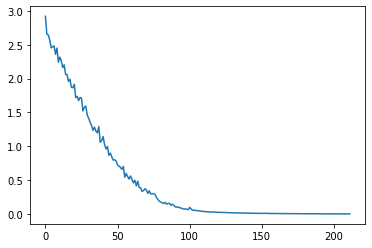

In [653]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)